# Phase curve analysis of KELT-1b TESS Sectors 17 and 57
## Appendix 1b: Plots assuming white noise

**Author:** Hannu Parviainen </br>
**Last updated:** 2 Feb 2023

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import xarray as xa
import seaborn as sb

from arviz.stats.density_utils import _kde_linear as kde

from pytransit.orbits import fold
from pytransit.utils.downsample import downsample_time_1d

In [3]:
from src.lpf import KELT1LPF
from src.kelt1 import AAOCW, AAPGW

In [4]:
lpf = KELT1LPF(noise_model='white')

In [5]:
lpf.ps

[  0 |G| tc             N(μ = 2455914.1628, σ = 0.01)            [    -inf ..      inf],
   1 |G| p              N(μ = 1.217513, σ = 4.5e-05)             [    0.00 ..      inf],
   2 |G| rho            N(μ = 0.5392592032228568, σ = 0.07529312598667542) [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |G| secw           N(μ = 0.0, σ = 1e-06)                    [   -1.00 ..     1.00],
   5 |G| sesw           N(μ = 0.0, σ = 1e-06)                    [   -1.00 ..     1.00],
   6 |P| k2             N(μ = 0.006084, σ = 0.001)               [    0.00 ..      inf],
   7 |G| oev            N(μ = 0.0, σ = 0.09)                     [    -inf ..      inf],
   8 |G| aev_T17        U(a = 0.0, b = 0.001)                    [    0.00 ..      inf],
   9 |G| adb_T17        U(a = 0, b = 1)                          [    0.00 ..      inf],
  10 |G| log10_ted_T17  U(a = -3.0, b = 0.0)                     [    -inf ..      inf],
  11 |G| lo

In [27]:
with xa.load_dataset('results/02_white_noise_fit.nc') as ds:
    df = pd.DataFrame(ds.mcmc_samples.values.reshape((-1, ds.parameter.size)),
                      columns=ds.parameter)

with xa.load_dataset('results/parviainen2022_03b.nc') as ds:
    dfc = pd.DataFrame(ds.mcmc_samples.values.reshape((-1, ds.parameter.size)),
                      columns=ds.parameter)

In [28]:
pvs = permutation(df.values)[:400]
pv = df.median().values
fms = lpf.flux_model(pvs)
bls = lpf.baseline(pvs)
bl = median(bls, 0)
sl = lpf.lcslices[1]

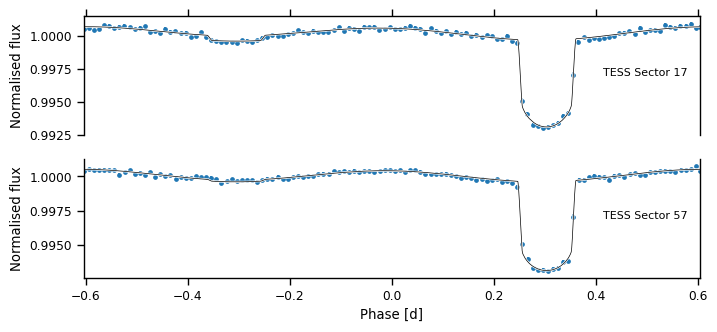

In [61]:
fm, fem, fep = percentile(fms, [50, 16, 84], 0)
aev = df.aev_T17.median()

labels = 'TESS Sector 17', 'TESS Sector 57'

with sb.plotting_context('paper'):
    fig, axs = subplots(2, 1, figsize=(AAPGW, 0.45*AAPGW), sharex='all')

    for i,sl in enumerate(lpf.lcslices):
        ax = axs[i]
        phase = fold(lpf.timea[sl], pv[1], pv[0], 0.25)
        sids = argsort(phase)
        phase = phase[sids]

        pb, fb, eb = downsample_time_1d(phase, lpf.ofluxa[sl][sids] / bl[sl][sids], 0.01)
        ax.errorbar(pb, fb, eb, fmt='.', zorder=0)
        ax.plot(phase, fm[sl][sids] / bl[sl][sids], 'w', lw=1.5, alpha=1)
        ax.plot(phase, fm[sl][sids] / bl[sl][sids], 'k', lw=0.5)
        ax.text(0.98, 0.5, labels[i], transform=ax.transAxes, ha='right', size='small')

    sb.despine(ax=axs[0], bottom=True, top=False, right=False)
    sb.despine(ax=axs[1], right=False)

    setp(axs, ylabel='Normalised flux', xlim=pb[[0,-1]])
    setp(axs[0].get_xticklabels(), visible=False)
    setp(axs[1], xlabel='Phase [d]')
    fig.tight_layout()
    fig.subplots_adjust(left=0.11, right=0.98, bottom=0.15, top=0.97)
    fig.savefig('plots/a01_phase_curve.pdf')

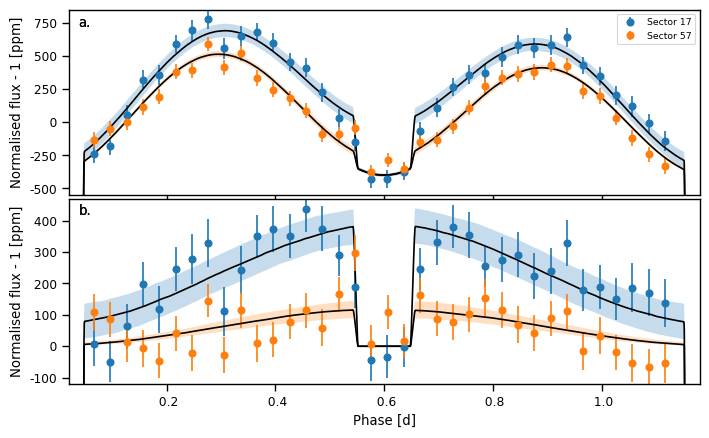

In [62]:
evs = lpf.ellipsoidal_variations(pvs)
dbs = lpf.doppler_boosting(pvs)
fma, fema, fepa = percentile(fms / bls, [50, 16, 84], 0)
fmb, femb, fepb = percentile(fms / bls - evs - dbs, [50, 16, 84], 0)
ev = median(evs, 0)
db = median(dbs, 0)

labels = 'Sector 17', 'Sector 57'

with sb.plotting_context('paper'):
    fig, axs = subplots(2, 1, figsize=(AAPGW, 0.6*AAPGW), sharex='all')
    for i,sl in enumerate(lpf.lcslices):
        phase = fold(lpf.timea[sl], pv[1], pv[0], 0.5)
        sids = argsort(phase)
        phase = phase[sids]
        
        ax = axs[0]
        pb, fb, eb = downsample_time_1d(phase, lpf.ofluxa[sl][sids]/bl[sl][sids], 0.03)
        ax.errorbar(pb, fb-1, eb, fmt='o', label=labels[i])
        ax.fill_between(phase, fema[sl][sids]-1, fepa[sl][sids]-1, alpha=0.25)
        ax.plot(phase, fma[sl][sids]-1, 'k')
        ax.text(0.015, 0.97, 'a.', transform=ax.transAxes, va='top', ha='left')

        ax = axs[1]
        pb, fb, eb = downsample_time_1d(phase, lpf.ofluxa[sl][sids] / bl[sl][sids] - ev[sl][sids] - db[sl][sids], 0.03)
        ax.errorbar(pb, fb-1, eb, fmt='o', label=labels[i])
        ax.fill_between(phase, femb[sl][sids]-1, fepb[sl][sids]-1, alpha=0.25)
        ax.plot(phase, fmb[sl][sids]-1, 'k')
        ax.text(0.015, 0.97, 'b.', transform=ax.transAxes, va='top', ha='left')

    [ax.yaxis.set_major_formatter(lambda x, pos: f"{1e6*x:4.0f}") for ax in axs]
    axs[1].xaxis.set_major_formatter(lambda x, pos: f"{x+0.5*pv[1]:4.1f}")

    axs[0].legend(fontsize='x-small')
    setp(axs[0], xlim=(-0.58, 0.58), ylim=(-0.00055, 0.00085), ylabel='Normalised flux - 1 [ppm]',)
    setp(axs[1], xlim=(-0.58, 0.58), ylim=(-0.00012, 0.00047), ylabel='Normalised flux - 1 [ppm]', xlabel='Phase [d]')
    fig.tight_layout()
    
    fig.subplots_adjust(left=0.1, right=0.99, bottom=0.1, top=0.98, hspace=0.02)
    fig.savefig('plots/a02_zoomed_phase_curve.pdf')

**Note:** The dayside surface brightness ratios are not the same as the maximum surface brightness ratios (because we allow for a free spot offset), but the difference is small enough that we can consider them equal here. 

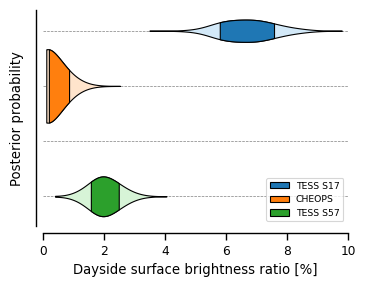

In [63]:
with sb.plotting_context('paper'):
    fig, ax = subplots(figsize=(AAOCW, 0.8*AAOCW))
    labels = 'TESS S17', 'CHEOPS', 'TESS S57'
    offsets = (0, 2, 6)
    for i,s in enumerate((df.log10_ted_T17, dfc.log10_ted_CHEOPS, df.log10_ted_T57)):
        d = 100*10**s
        x, y = kde(d, bw=0.3)
        yoffset = offsets[i]
        ax.fill_between(x, -y-yoffset, y-yoffset, fc=sb.utils.set_hls_values(f'C{i}', l=0.9), ec='k')
        p = percentile(d, [16, 84])
        m = (x > p[0]) & (x < p[1])
        ax.fill_between(x[m], -y[m]-yoffset, y[m]-yoffset, fc=f'C{i}', ec='k', label=labels[i])
    [ax.axhline(-v, zorder=-5, c='0.5', ls='--', lw=0.5) for v in arange(0,7,2)]
    ax.legend(fontsize='x-small', loc=4)
    sb.despine(fig, offset=5)
    setp(ax, xlabel='Dayside surface brightness ratio [%]', yticks=[], ylabel='Posterior probability', xlim=(0, 10))
    fig.tight_layout()
    fig.subplots_adjust(left=0.1, right=0.98, bottom=0.2, top=0.98, hspace=0.02)
fig.savefig('plots/a03_brightness_ratios.pdf')

---

<center>&copy;2023 Hannu Parviainen</center>